In [40]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

from utils import Pyutils as pyutils

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (15,10)

SOURCE_PATH = os.getcwd()
INPUTS_PATH = os.path.join(SOURCE_PATH, "data", "inputs")
OUTPUTS_PATH = os.path.join(SOURCE_PATH, "data", "outputs")
DATASET_NAMES = ["betadgp_covdgp_data", "betadgp_beta2x2_data", "betadgp_data"]
TARGET_NAME = "betas_dgp"
MODEL_TAGS = ["linear_reg", "ffnn"]

## 1) Aggregate all results

In [94]:
all_data = []
ffnn_achitectures = []
idx = 0
for model_tag in tqdm(MODEL_TAGS,
                      desc="Append all model results"):
    
    DGPS = os.listdir(os.path.join(OUTPUTS_PATH, model_tag))
    for dgp_name in DGPS:
        for ds in DATASET_NAMES:
            
            data = pd.read_csv(os.path.join(OUTPUTS_PATH, model_tag, dgp_name, ds + "_result.csv"))
            data["model"] = model_tag
            data["dgp"] = dgp_name
            data["dataset"] = ds
            
            if model_tag == "ffnn":
                mse = mean_squared_error(y_true=data["y"],
                                         y_pred=data["pred"])
                mae = mean_absolute_error(y_true=data["y"],
                                          y_pred=data["pred"])
                    
                ffnn_tmp = pyutils.load_pkl(path=os.path.join(OUTPUTS_PATH, model_tag, dgp_name, ds + "_model.pickle"))
                ffnn_tmp["model"] = model_tag
                ffnn_tmp["dgp"] = dgp_name
                ffnn_tmp["number_of_variables"] = int(ffnn_tmp['dgp'].split("_")[1])
                ffnn_tmp["dataset"] = ds
                ffnn_tmp["mse"] = mse
                ffnn_tmp["mae"] = mae

                ffnn_achitectures.append(pd.DataFrame(ffnn_tmp, index=[idx]))
                idx += 1
            
            all_data.append(data)
all_data_df = pd.concat(all_data, axis=0)
ffnn_achitectures_df = pd.concat(ffnn_achitectures, axis=0)

Append all model results: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


## 2) Compute relevant metrics

> a) Mean squared error

> b) Mean absolute error

In [70]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mse_melt(v):
    mse = mean_squared_error(y_true=v["y"],
                             y_pred=v["pred"])
    return pd.Series(dict(mse=mse))

def mae_melt(v):
    mae = mean_absolute_error(y_true=v["y"],
                             y_pred=v["pred"])
    return pd.Series(dict(mae=mae))

metrics_df = all_data_df.drop(["Var1", "Var2"], axis=1)
mse_group_df = metrics_df.groupby(["model", "dgp", "dataset"]).apply(mse_melt).reset_index()
mae_group_df = metrics_df.groupby(["model", "dgp", "dataset"]).apply(mae_melt).reset_index()

### MSE histogram

Text(0.5, 1.0, 'MSE of the OOS forecast for each test simulation')

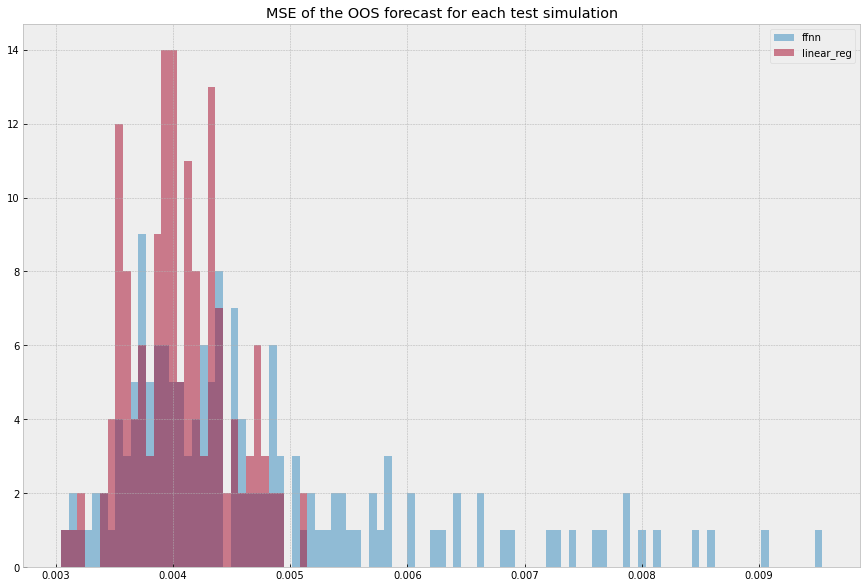

In [71]:
ffnn_hist_mse = mse_group_df.loc[mse_group_df["model"]=="ffnn"][["mse"]]
ffnn_hist_mse.rename(columns={"mse": "ffnn mse"}, inplace=True)

linear_reg_hist_mse = mse_group_df.loc[mse_group_df["model"]=="linear_reg"][["mse"]]
linear_reg_hist_mse.rename(columns={"mse": "linear_reg mse"}, inplace=True)

hist_mse_df = pd.concat([ffnn_hist_mse.reset_index(drop=True), linear_reg_hist_mse.reset_index(drop=True)], axis=1)

bins = np.linspace(hist_mse_df.min().min(), hist_mse_df.max().max(), 100)
plt.hist(hist_mse_df[hist_mse_df.columns[0]], bins, alpha=0.5, label='ffnn')
plt.hist(hist_mse_df[hist_mse_df.columns[1]], bins, alpha=0.5, label='linear_reg')
plt.legend(loc='upper right')
plt.title("MSE of the OOS forecast for each test simulation")

### MAE histogram

Text(0.5, 1.0, 'MAE of the OOS forecast for each test simulation')

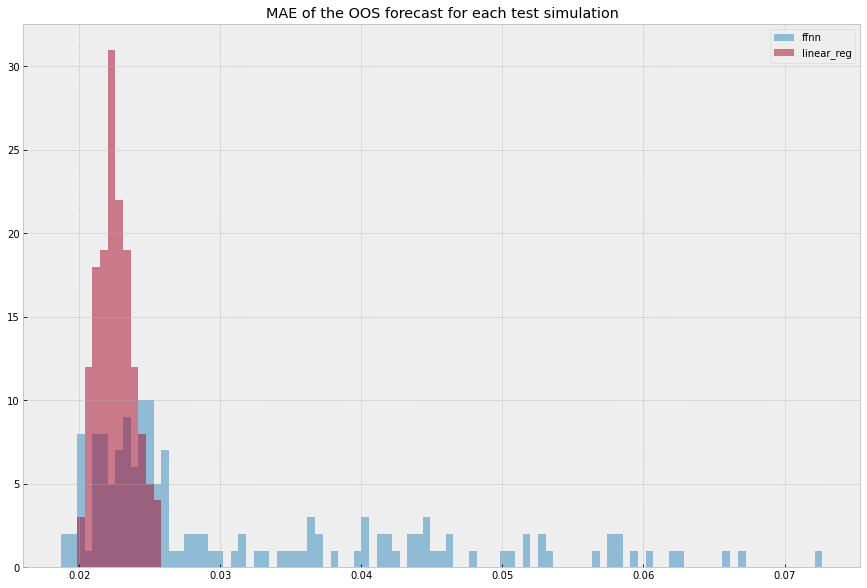

In [72]:
ffnn_hist_mae = mae_group_df.loc[mae_group_df["model"]=="ffnn"][["mae"]]
ffnn_hist_mae.rename(columns={"mae": "ffnn mae"}, inplace=True)

linear_reg_hist_mae = mae_group_df.loc[mae_group_df["model"]=="linear_reg"][["mae"]]
linear_reg_hist_mae.rename(columns={"mae": "linear_reg mae"}, inplace=True)

hist_mae_df = pd.concat([ffnn_hist_mae.reset_index(drop=True), linear_reg_hist_mae.reset_index(drop=True)], axis=1)

bins = np.linspace(hist_mae_df.min().min(), hist_mae_df.max().max(), 100)
plt.hist(hist_mae_df[hist_mae_df.columns[0]], bins, alpha=0.5, label='ffnn')
plt.hist(hist_mae_df[hist_mae_df.columns[1]], bins, alpha=0.5, label='linear_reg')
plt.legend(loc='upper right')
plt.title("MAE of the OOS forecast for each test simulation")

## 3) Analysis of the chosen FFNN architectures

### Distribution of the number of hidden units and neurons per unit

Text(0.5, 1.0, 'Distribution of the number of hidden units in each chosen ffnn')

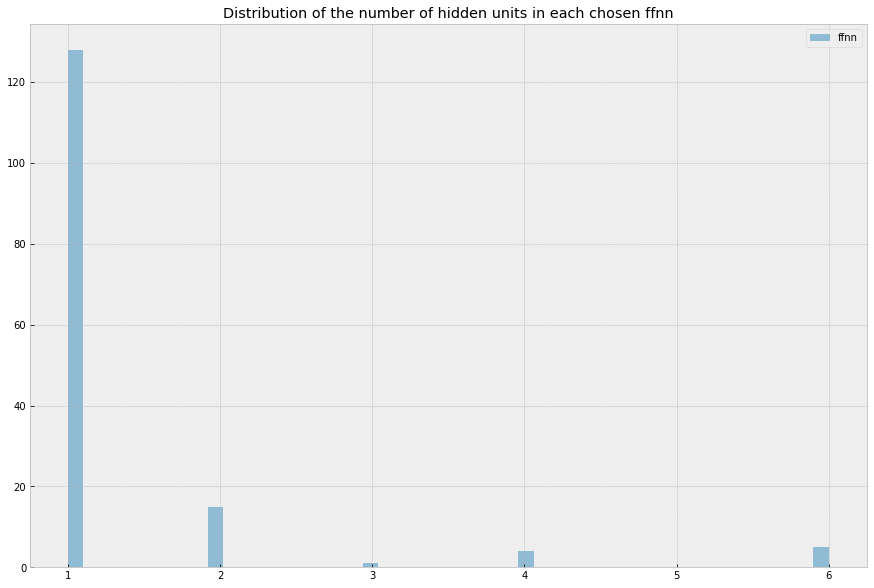

In [95]:
bins = np.linspace(ffnn_achitectures_df['n_hidden'].min(), ffnn_achitectures_df['n_hidden'].max(), 50)
plt.hist(ffnn_achitectures_df['n_hidden'], bins, alpha=0.5, label='ffnn')
plt.legend(loc='upper right')
plt.title("Distribution of the number of hidden units in each chosen ffnn")

Text(0.5, 1.0, 'Distribution of the number of neurons per hidden units in each chosen ffnn')

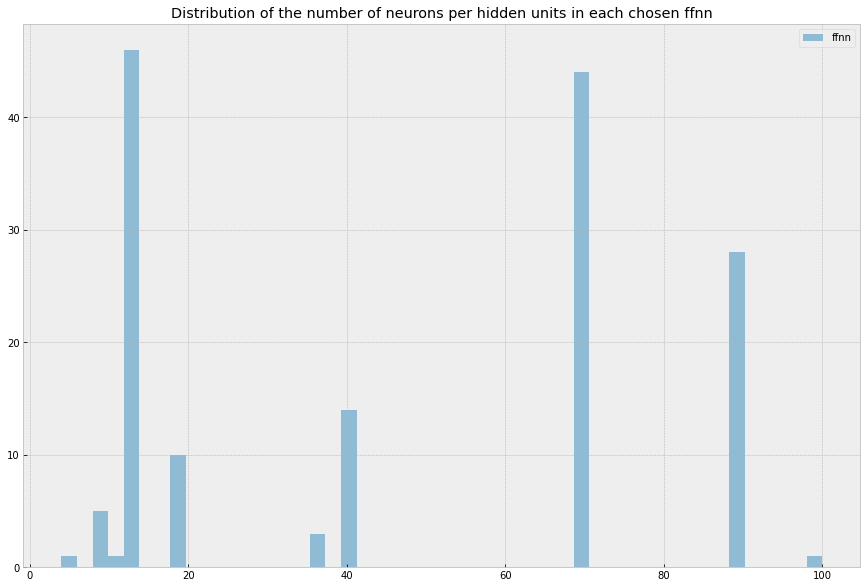

In [96]:
bins = np.linspace(ffnn_achitectures_df['n_neurons'].min(), ffnn_achitectures_df['n_neurons'].max(), 50)
plt.hist(ffnn_achitectures_df['n_neurons'], bins, alpha=0.5, label='ffnn')
plt.legend(loc='upper right')
plt.title("Distribution of the number of neurons per hidden units in each chosen ffnn")

### Analysis of the parameters of the best ffnn architectures

In [97]:
ffnn_achitectures_df.sort_values("mse", ascending=True).head(20)

,activation,input_shape,learning_rate,loss,n_hidden,n_neurons,model,dgp,number_of_variables,dataset,mse,mae
12,relu,1,0.000574,mse,1,13,ffnn,ar1_195_random,195,betadgp_covdgp_data,0.003065,0.021041
13,relu,1,0.022396,mse,1,70,ffnn,ar1_195_random,195,betadgp_beta2x2_data,0.003118,0.021996
24,relu,1,0.022396,mse,1,70,ffnn,ar1_197_random,197,betadgp_covdgp_data,0.003171,0.020143
78,relu,1,0.022842,mse,1,90,ffnn,ar1_194_random,194,betadgp_covdgp_data,0.003223,0.019957
117,relu,1,0.020633,mse,2,40,ffnn,ar1_196_random,196,betadgp_covdgp_data,0.003272,0.021251
42,relu,1,0.022396,mse,1,70,ffnn,ar1_193_random,193,betadgp_covdgp_data,0.003341,0.020730
3,relu,1,0.009477,mse,6,8,ffnn,ar1_174_random,174,betadgp_covdgp_data,0.003363,0.020313
111,relu,1,0.022842,mse,1,90,ffnn,ar1_184_random,184,betadgp_covdgp_data,0.003405,0.019348
81,relu,1,0.024473,mse,4,37,ffnn,ar1_186_random,186,betadgp_covdgp_data,0.003419,0.021318
39,relu,1,0.022396,mse,1,70,ffnn,ar1_176_random,176,betadgp_covdgp_data,0.003487,0.018784


<AxesSubplot:title={'center':'Average MSE for each DGP with a given number of variables'}, xlabel='number_of_variables'>

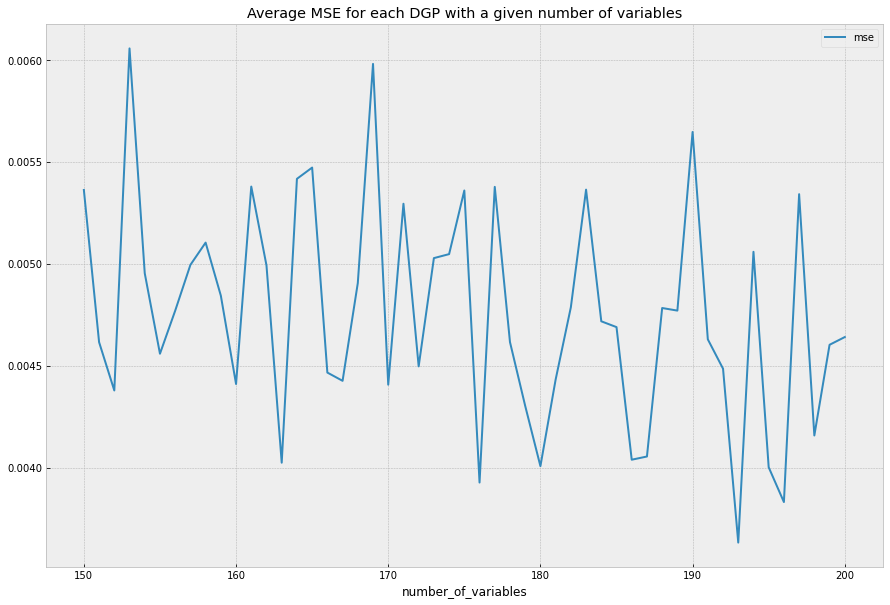

In [106]:
ffnn_achitectures_df[["number_of_variables", "mse"]].groupby("number_of_variables").mean().plot(title="Average MSE for each DGP with a given number of variables")